<a href="https://colab.research.google.com/github/youmnanasser/Transfer-Learning-COVID-CT-Scan/blob/main/Transfer_Learning_for_COVID_CT_Scan_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 23.92 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!pip install split-folders

# Connect to Drive

In [2]:
from google.colab import drive, files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [7]:
%rm -r data

rm: cannot remove 'data': No such file or directory


In [8]:
from pathlib import Path
# Setup path to data folder
data_path = Path("data/")
image_path_covid = data_path / "covid-data"
if image_path_covid.is_dir():
    print(f"{image_path_covid} directory exists.")
else:
    print(f"Did not find {image_path_covid} directory, creating one...")
    image_path_covid.mkdir(parents=True, exist_ok=True)

image_path_non_covid = data_path / "non-covid-data"
if image_path_non_covid.is_dir():
    print(f"{image_path_non_covid} directory exists.")
else:
    print(f"Did not find {image_path_non_covid} directory, creating one...")
    image_path_non_covid.mkdir(parents=True, exist_ok=True)

Did not find data/covid-data directory, creating one...
Did not find data/non-covid-data directory, creating one...


In [10]:
import splitfolders

input_folder_covid = "/content/drive/MyDrive/Colab Notebooks/covid_ct_scan/CT_COVID"
input_folder_non_covid = "/content/drive/MyDrive/Colab Notebooks/covid_ct_scan/CT_NonCOVID"


splitfolders.ratio(input_folder_covid, output=image_path_covid, seed=42, ratio=(.8, .2))
splitfolders.ratio(input_folder_non_covid, output=image_path_non_covid, seed=42, ratio=(.8, .2))


Copying files: 0 files [00:00, ? files/s]
Copying files: 4 files [00:00,  5.35 files/s]
Copying files: 5 files [00:01,  3.69 files/s]
Copying files: 6 files [00:03,  1.24 files/s]
Copying files: 7 files [00:04,  1.18 files/s]
Copying files: 19 files [00:04,  6.41 files/s]
Copying files: 23 files [00:05,  6.27 files/s]
Copying files: 42 files [00:05, 13.47 files/s]
Copying files: 63 files [00:06, 20.05 files/s]
Copying files: 86 files [00:06, 33.64 files/s]
Copying files: 102 files [00:06, 39.17 files/s]
Copying files: 111 files [00:07, 21.40 files/s]
Copying files: 133 files [00:08, 21.85 files/s]
Copying files: 158 files [00:09, 34.31 files/s]
Copying files: 169 files [00:09, 24.69 files/s]
Copying files: 188 files [00:10, 34.66 files/s]
Copying files: 212 files [00:10, 50.82 files/s]
Copying files: 227 files [00:10, 39.71 files/s]
Copying files: 239 files [00:11, 34.31 files/s]
Copying files: 260 files [00:11, 48.87 files/s]
Copying files: 285 files [00:11, 70.21 files/s]
Copying fi

In [11]:
import os
os.replace('/content/data/non-covid-data/train/CT_NonCOVID','/content/data/covid-data/train/CT_NonCOVID')
os.replace('/content/data/non-covid-data/val/CT_NonCOVID', '/content/data/covid-data/val/CT_NonCOVID')
os.replace('/content/data/covid-data/val', '/content/data/val')
os.replace('/content/data/covid-data/train', '/content/data/train')

In [12]:
%rm -r /content/data/covid-data
%rm -r /content/data/non-covid-data

In [13]:
# Setup Dirs
train_dir = data_path / "train"
test_dir = data_path / "val"

## Choosing a Pre-trained Model (EfficientNet_B0)

In [14]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [15]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b72223aa4a0>,
 ['CT_COVID', 'CT_NonCOVID'])

In [17]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth

  0%|          | 0.00/20.5M [00:00<?, ?B/s]
100%|██████████| 20.5M/20.5M [00:00<00:00, 158MB/s]


In [18]:
# Print a summary using torchinfo
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [19]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

### Recreating the Classifier Layer with Different Parameters

In [20]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.4, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [21]:
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Training the Model

In [22]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [24]:

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results_eff_1 = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=25,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.6359 | train_acc: 0.6406 | test_loss: 2.5046 | test_acc: 0.6333
Epoch: 2 | train_loss: 1.3639 | train_acc: 0.7686 | test_loss: 1.2576 | test_acc: 0.7042
Epoch: 3 | train_loss: 1.1826 | train_acc: 0.7882 | test_loss: 1.7564 | test_acc: 0.6896
Epoch: 4 | train_loss: 1.2924 | train_acc: 0.7679 | test_loss: 1.9640 | test_acc: 0.6917
Epoch: 5 | train_loss: 1.2517 | train_acc: 0.7589 | test_loss: 1.4826 | test_acc: 0.7063
Epoch: 6 | train_loss: 0.9880 | train_acc: 0.8053 | test_loss: 1.5886 | test_acc: 0.7479
Epoch: 7 | train_loss: 1.2664 | train_acc: 0.7654 | test_loss: 1.6352 | test_acc: 0.7479
Epoch: 8 | train_loss: 1.4905 | train_acc: 0.7592 | test_loss: 1.7551 | test_acc: 0.6979
Epoch: 9 | train_loss: 1.5907 | train_acc: 0.7765 | test_loss: 1.9973 | test_acc: 0.7083
Epoch: 10 | train_loss: 1.3261 | train_acc: 0.8185 | test_loss: 2.0382 | test_acc: 0.7208
Epoch: 11 | train_loss: 1.6041 | train_acc: 0.7994 | test_loss: 2.6429 | test_acc: 0.6188
Epoch: 12 | train_l

## Choosing Another Pre-trained Model (RestNet)

In [73]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ResNet50_Weights.IMAGENET1K_V2

In [74]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [75]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b7128ac8700>,
 ['CT_COVID', 'CT_NonCOVID'])

In [76]:
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.resnet50(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 38.0MB/s]


In [77]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Recreating the FC Layer by Adding Additional Functions

In [78]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.fc = torch.nn.Sequential(
     nn.Linear(2048, 2048),
      nn.Dropout(0.5),
      nn.Linear(2048, 2048),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(2048,
      out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [79]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training the Model

In [80]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [81]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [83]:

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results_resnet = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=30,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 120.0077 | train_acc: 0.5749 | test_loss: 13.6255 | test_acc: 0.4437
Epoch: 2 | train_loss: 145.0936 | train_acc: 0.4960 | test_loss: 1.4454 | test_acc: 0.4500
Epoch: 3 | train_loss: 33.8913 | train_acc: 0.5218 | test_loss: 5.5632 | test_acc: 0.4375
Epoch: 4 | train_loss: 20.9683 | train_acc: 0.5521 | test_loss: 42.0886 | test_acc: 0.4375
Epoch: 5 | train_loss: 4.0577 | train_acc: 0.5322 | test_loss: 34.5290 | test_acc: 0.6062
Epoch: 6 | train_loss: 12.4407 | train_acc: 0.5196 | test_loss: 24.5301 | test_acc: 0.6125
Epoch: 7 | train_loss: 83.9813 | train_acc: 0.4692 | test_loss: 5.1696 | test_acc: 0.4313
Epoch: 8 | train_loss: 19.5260 | train_acc: 0.5451 | test_loss: 16.7259 | test_acc: 0.6125
Epoch: 9 | train_loss: 30.2270 | train_acc: 0.5464 | test_loss: 7.7745 | test_acc: 0.4375
Epoch: 10 | train_loss: 13.2745 | train_acc: 0.5203 | test_loss: 4.7753 | test_acc: 0.4313
Epoch: 11 | train_loss: 0.9549 | train_acc: 0.5352 | test_loss: 13.9781 | test_acc: 0.6125
Ep

# Models Evaluation

[INFO] Couldn't find helper_functions.py, downloading...


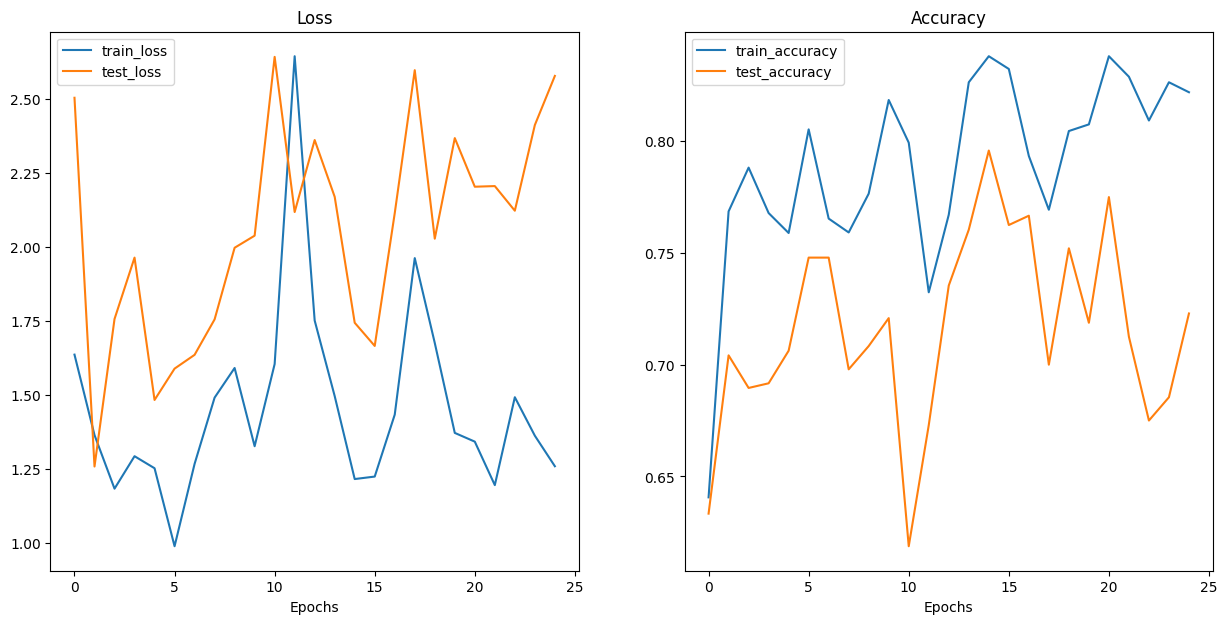

In [84]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results_eff_1)

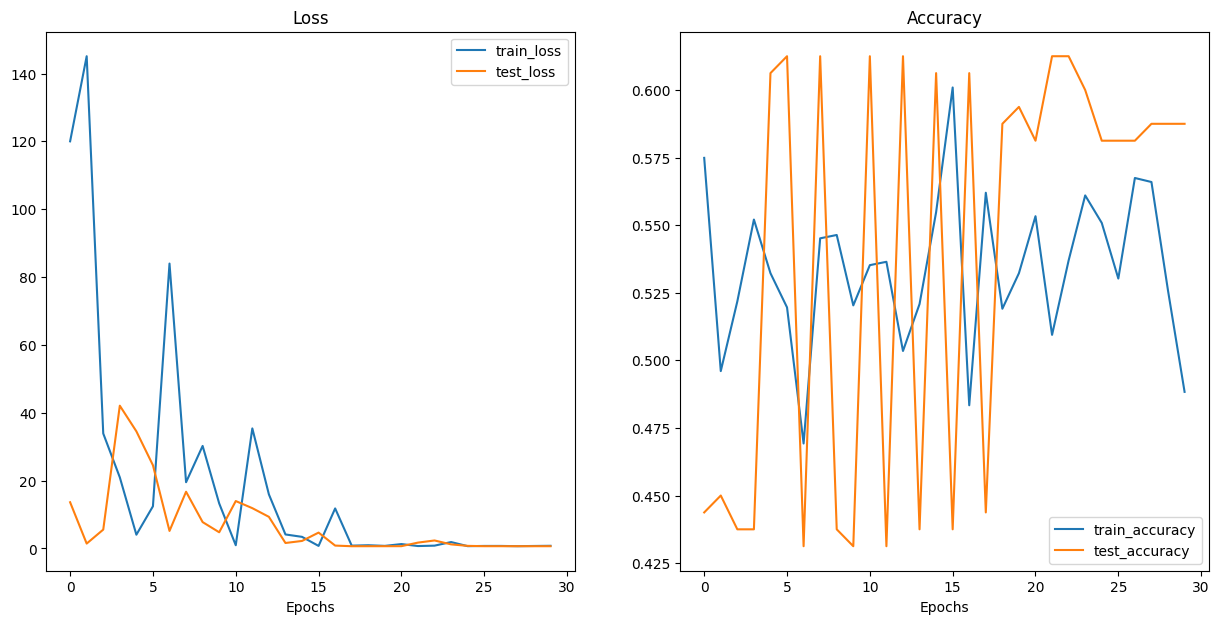

In [86]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results_resnet)